# Spectral Clustering
written by Eric Bridgeford and Theodor Marinov

In this notebook, we will investigate the Spectral clustering implementation provided for our course project.

## Algorithm Basics

The algorithm used here is Spectral clustering as implemented in the Andrew Ng paper.

### Spectral Cluster Ng

Given: $X = \begin{bmatrix} x_1 & \ldots & x_n\end{bmatrix}$, $K(x, y)$ a kernel function

1. $A_{ij} = K(x_i, x_j)$
2. $D = A.sum(columnwise)I$, a diagonal matrix whose entries are the columnwise sums of $A$
3. $L = D^{\frac{1}{2}}AD^{\frac{1}{2}}$
4. $(U, S, V^*) = SVD(L)$
5. $U_k = U[:, 0:k]$, the top $k$ left singular vectors
6. $Y_i = U_{k, i}/||U_{k, i}||$, the normalized left singular vectors
7. Cluster $Y$ using K-means clustering

Here, we will concern ourselves with the RBF kernel

# Simulations

## Basic Simulation - Perfectly Separable Spectral

For our first basic simulation, we will check how well our algorithm performs on the canonical form for a dataset that should be clusterable with spectral clustering using the RBF kernel, points distributed on a unit sphere with a smaller unit sphere with noise.

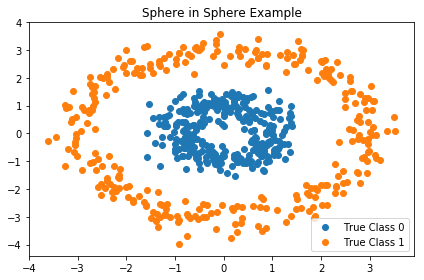

In [20]:
%matplotlib inline
import numpy as np
from clustering import Kmeans, Spectral
from clustering.kernel import RBF_kernel
from clustering.utils import purity, plot_laplacian
import matplotlib.pyplot as plt


def sample_ball(r, dim=2, n=100, s=0):
    """
    A function to sample from the unit ball, given an input radius.
    """
    u = np.random.randn(dim, n)
    unorm = np.sqrt(np.sum(np.square(u), axis=0))*np.identity(n)
    return r*u.dot(np.linalg.pinv(unorm)) + s*np.random.randn(dim, n)

n=300
dim=2
s=0.3
data1 = sample_ball(r=1, dim=dim, n=n, s=s)
data2 = sample_ball(r=3, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Sphere in Sphere Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

We perform our clustering:

In [21]:
km = Kmeans(K=2, wt=True)
sp = Spectral(dim=2, kernel=RBF_kernel(0.25), clust=km, method='Bach')
sp.fit(data)

The first visualization we will do is the graph laplacian. We expect to have pairs of points that are part of the same cluster have greater values:

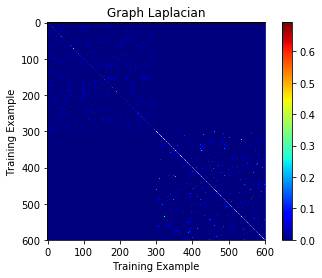

In [27]:
spec_dat = sp.spectral_data().dot(np.reciprocal(np.sqrt(sp._d))*np.identity(n*2,))
spec_cent = sp.spectral_centers()

L = sp.get_laplacian()
flap = plot_laplacian(L)

Which we can see is, in fact, the case (we kept our data ordered here so that our laplacian would make intuitive sense, but succeeding examles will randomly permute the labels). Next, let's take a look at our data in the spectral domain:

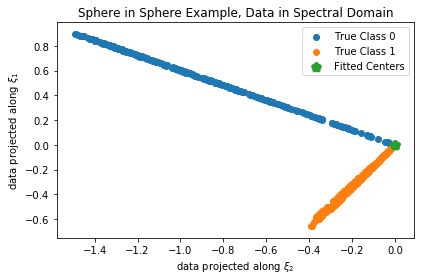

In [28]:
# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(spec_dat[0, true_labels == 0], spec_dat[1, true_labels == 0])
scat2 = ax.scatter(spec_dat[0, true_labels == 1], spec_dat[1, true_labels == 1])
scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3),
          ('True Class 0', 'True Class 1', 'Fitted Centers'),
          loc='upper right')
ax.set_ylabel(r'data projected along $\xi_1$')
ax.set_xlabel(r'data projected along $\xi_2$')
fig.tight_layout()
fig.show()

And the assigned clusters:

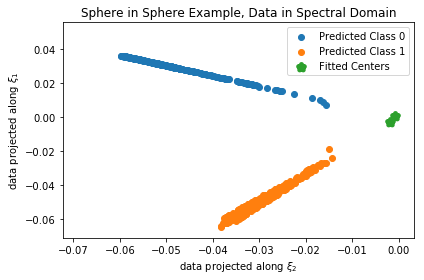

In [25]:
# visualize
pred_labels = sp.get_assignments()
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(spec_dat[0, pred_labels == 0],
                   spec_dat[1, pred_labels == 0])
scat2 = ax.scatter(spec_dat[0, pred_labels == 1],
                   spec_dat[1, pred_labels == 1])
scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3),
          ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
          loc='upper right')
ax.set_ylabel(r'data projected along $\xi_1$')
ax.set_xlabel(r'data projected along $\xi_2$')
fig.tight_layout()
fig.show()

Next, we will look at the predicted labels, and the confusion matrix associated:

purity = 1.0


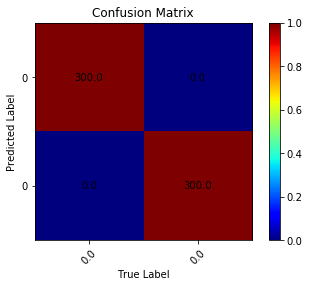

In [26]:
(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

## Basic Simulation - Perfectly Separable Spectral, 3 Spheres

For our next example, we will again use perfectly separable data, but this time with 3 spheres:

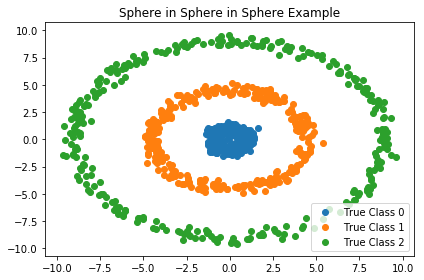

In [7]:
n=300
dim=2
s=0.3
data1 = sample_ball(r=1, dim=dim, n=n, s=s)
data2 = sample_ball(r=4.5, dim=dim, n=n, s=s)
data3 = sample_ball(r=9, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,)),
                              2*np.ones((n,))))
data = np.hstack((data1, data2, data3))
idx = range(0, len(true_labels))
np.random.shuffle(idx)
#randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
scat3 = ax.scatter(data[0, true_labels == 2], data[1, true_labels == 2])
ax.set_title('Sphere in Sphere in Sphere Example')
ax.legend((scat1, scat2, scat3), ('True Class 0', 'True Class 1', 'True Class 2'),
          loc='lower right')
fig.tight_layout()
fig.show()

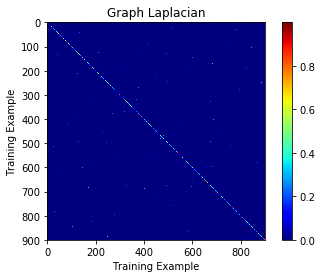

In [8]:
km = Kmeans(K=3)
sp = Spectral(dim=3, kernel=RBF_kernel(np.sqrt(0.05)), clust=km, method='Ng')
sp.fit(data)

spec_dat = sp.spectral_data()
spec_cent = sp.spectral_centers()
pred_labels = sp.get_assignments()

L = sp.get_laplacian()
flap = plot_laplacian(L)

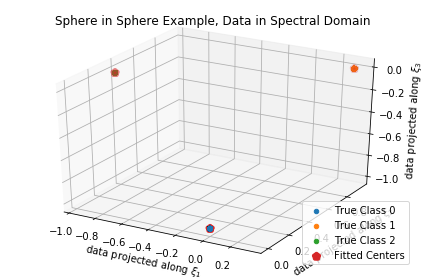

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat1 = ax.scatter(spec_dat[0, true_labels == 0],
                   spec_dat[1, true_labels == 0],
                   spec_dat[2, true_labels == 0])
scat2 = ax.scatter(spec_dat[0, true_labels == 1],
                   spec_dat[1, true_labels == 1],
                   spec_dat[2, true_labels == 1])
scat3 = ax.scatter(spec_dat[0, true_labels == 2],
                   spec_dat[1, true_labels == 2],
                   spec_dat[2, true_labels == 2])
scat4 = ax.scatter(spec_cent[0, :], spec_cent[1, :], spec_cent[2, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3, scat4),
          ('True Class 0', 'True Class 1', 'True Class 2', 'Fitted Centers'),
          loc='lower right')
ax.set_xlabel(r'data projected along $\xi_1$')
ax.set_ylabel(r'data projected along $\xi_2$')
ax.set_zlabel(r'data projected along $\xi_3$')
fig.tight_layout()
fig.show()

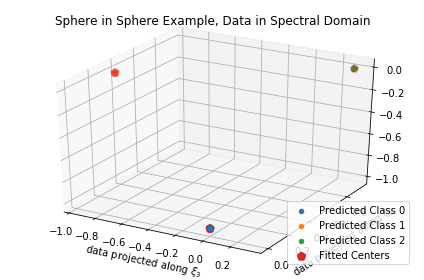

In [10]:
# visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat1 = ax.scatter(spec_dat[0, pred_labels == 0],
                   spec_dat[1, pred_labels == 0],
                   spec_dat[2, pred_labels == 0])
scat2 = ax.scatter(spec_dat[0, pred_labels == 1],
                   spec_dat[1, pred_labels == 1],
                   spec_dat[2, pred_labels == 1])
scat3 = ax.scatter(spec_dat[0, pred_labels == 2],
                   spec_dat[1, pred_labels == 2],
                   spec_dat[2, pred_labels == 2])
scat4 = ax.scatter(spec_cent[0, :], spec_cent[1, :], spec_cent[2, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3, scat4),
          ('Predicted Class 0', 'Predicted Class 1', 'Predicted Class 2', 'Fitted Centers'),
          loc='lower right')
ax.set_xlabel(r'data projected along $\xi_1$')
ax.set_ylabel(r'data projected along $\xi_2$')
ax.set_xlabel(r'data projected along $\xi_3$')
fig.tight_layout()
fig.show()

purity = 1.0


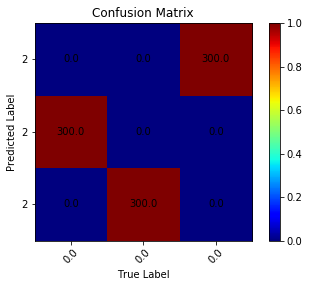

In [11]:
(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

Again, our algorithm does a good job on the given data.

# Hard Example: Sphere overlapping Sphere

Next, we will consider the case when we have a sphere overlapping a sphere:

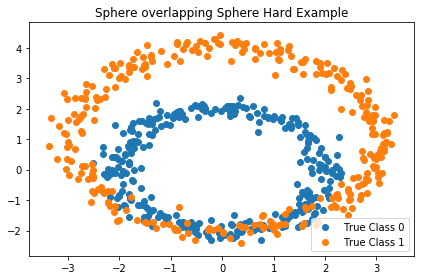

In [12]:
n=300
dim=2
s=0.2
data1 = sample_ball(r=2, dim=dim, n=n, s=s)
new_mean = np.identity(dim)
new_mean[0] = 0
data2 = sample_ball(r=3, dim=dim, n=n, s=s) + new_mean.dot(np.ones((dim, n)))
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Sphere overlapping Sphere Hard Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

Here, we will do a parameter sweep over sigma to find the sigma that gives us the optimal classification, where we define the "best" classification as the classification that maximizes the purity:

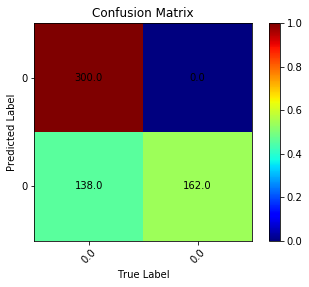

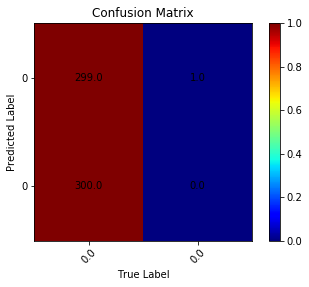

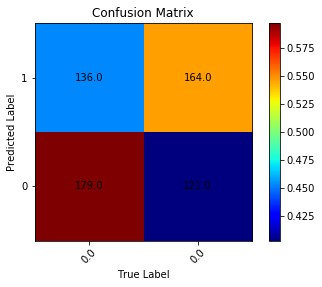

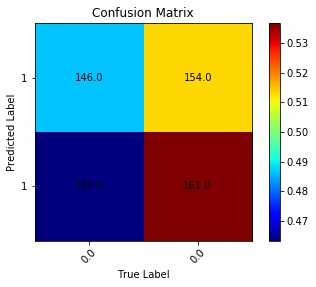

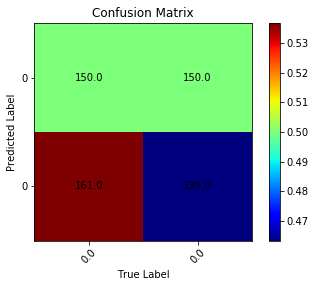

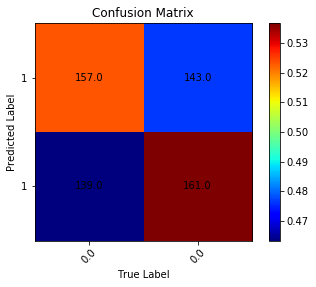

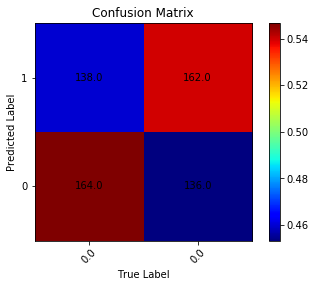

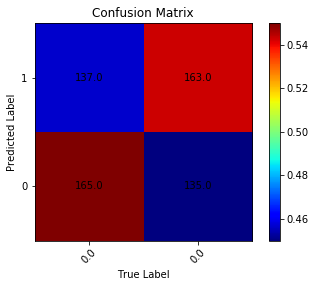

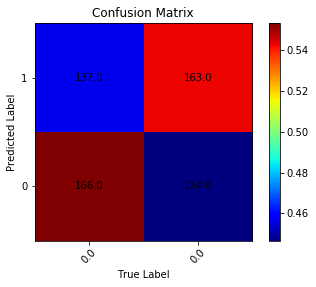

In [13]:
sig_check = [np.sqrt(0.05), 0.1, 0.5, 1, 1.5, 2, 3, 4, 5]
pur = []

for sig in sig_check:
    km = Kmeans(K=2)
    RBF_kernel(2)
    sp = Spectral(dim=2, kernel=RBF_kernel(sig), clust=km, method='Ng')
    sp.fit(data)
    pred_labels = sp.get_assignments()
    pur.append(purity(true_labels, pred_labels)[0])
max_sig = sig_check[np.argmax(np.array(purity))]

In [19]:
km = Kmeans(K=2)
RBF_kernel(2)
sp = Spectral(dim=2, kernel=RBF_kernel(max_sig), clust=km, method='Ng')
sp.fit(data)
pred_labels = sp.get_assignments()

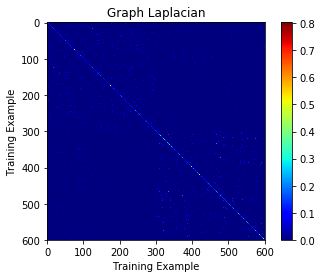

In [20]:
spec_dat = sp.spectral_data()
spec_cent = sp.spectral_centers()

L = sp.get_laplacian()
flap = plot_laplacian(L)

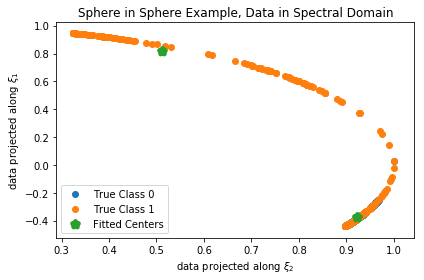

In [21]:
# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(spec_dat[0, true_labels == 0], spec_dat[1, true_labels == 0])
scat2 = ax.scatter(spec_dat[0, true_labels == 1], spec_dat[1, true_labels == 1])
scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3),
          ('True Class 0', 'True Class 1', 'Fitted Centers'),
          loc='lower left')
ax.set_ylabel(r'data projected along $\xi_1$')
ax.set_xlabel(r'data projected along $\xi_2$')
fig.tight_layout()
fig.show()

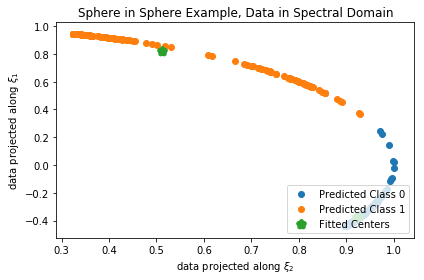

In [22]:
# visualize
pred_labels = sp.get_assignments()
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(spec_dat[0, pred_labels == 0],
                   spec_dat[1, pred_labels == 0])
scat2 = ax.scatter(spec_dat[0, pred_labels == 1],
                   spec_dat[1, pred_labels == 1])
scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3),
          ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
          loc='lower right')
ax.set_ylabel(r'data projected along $\xi_1$')
ax.set_xlabel(r'data projected along $\xi_2$')
fig.tight_layout()
fig.show()

purity = 0.775


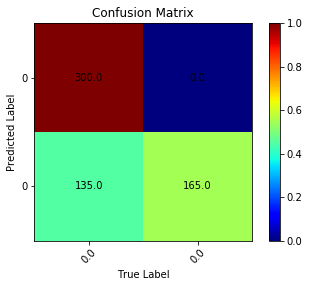

In [23]:
(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()

And we get terrible classification as we might expect.

(1000, 1000)


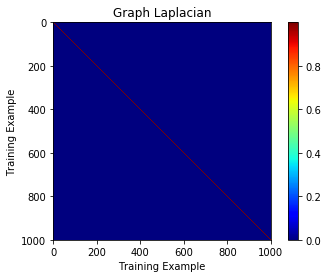

In [19]:
#MATRIX EXAMPLE
d = 30
m = 50
num = 500
M1 = np.random.randn(d,m,num) + 10;
M2 = np.random.randn(d,m,num) - 10;
true_labels = np.concatenate((0*np.ones((num,)), 1*np.ones((num,))))
matrices = np.concatenate((M1, M2),axis=2)
matrices.shape
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
matrices = matrices[:, :, idx]
#np.random.shuffle(idx)
# randomly permute
true_labels = true_labels[idx]

sp = Spectral(dim=2, kernel=RBF_kernel(np.sqrt(100),'fro'), clust=km, method='Ng')
sp.fit(matrices)

spec_dat = sp.spectral_data()
spec_cent = sp.spectral_centers()
pred_labels = sp.get_assignments()

L = sp.get_laplacian()
flap = plot_laplacian(L)

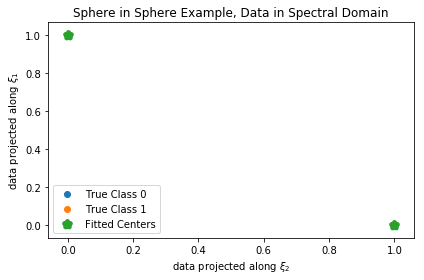

In [22]:
# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(spec_dat[0, true_labels == 0], spec_dat[1, true_labels == 0])
scat2 = ax.scatter(spec_dat[0, true_labels == 1], spec_dat[1, true_labels == 1])
scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                   marker='*', linewidths=5)
ax.set_title('Sphere in Sphere Example, Data in Spectral Domain')
ax.legend((scat1, scat2, scat3),
          ('True Class 0', 'True Class 1', 'Fitted Centers'),
          loc='lower left')
ax.set_ylabel(r'data projected along $\xi_1$')
ax.set_xlabel(r'data projected along $\xi_2$')
fig.tight_layout()
fig.show()

purity = 1.0


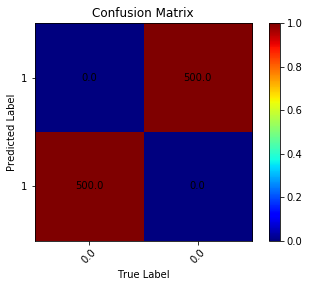

In [23]:
(p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
print ("purity = {}".format(p))
fig_conf.show()